<a href="https://colab.research.google.com/github/roesta07/Notes/blob/main/MCMC_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')
# %load_ext watermark
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

# Approximation of Unknown Mean and Sigma of Normal Distribution
A glimpse of how MCMC sampler works; a Note to self<br>
*keywords: Python,Metropolis-Hasting*

Behind every model, there are underlying algorithms that extract and weigh information from the Data. Over the years we have used many ad-hoc methods and tests like t-test, Wilcoxon rank test, etc for building such models. But not every problem has an analytical solution and also since we can extensively use our computational powers over the year we can use our computers to search any space to look for plausible values.


#Assumption about data
$P(data)\sim Normal(mu,sigma)$<br>


In [ ]:
# Assuming data generates from some process which are distributed Normally;
# We are trying to estimate the parameters for Normal Distribution i.e Mu and sigma 
data=stats.norm().rvs(5)
data

array([ 1.09504603,  0.51221901, -0.38213464, -0.78353963,  0.5034203 ])


## Grid Appromiximation
Thus first; we are using grid approximation which is just weighting every space on a grid range. And the weighting is just done using Bay's rule.

In [ ]:
## lets first use grid-appromixation for both mu and sigma
mu_x=np.linspace(-5,5,500)
sigma_x=np.linspace(0,5,500)
## this is the grid we are serching for
points = np.mgrid[-5:5:0.05, 1:5:0.05].reshape(2,-1).T
## calculate posterior
prior_mu=stats.norm.logpdf(points[:,0],loc=0,scale=10)
prior_sigma=stats.uniform.logpdf(points[:,1],1,5)
liklihood=[ sum(stats.norm.logpdf(data,loc=points[:,0][i],scale=points[:,1][i]) )
            for i in range(len(points))]
unnormalized_log_posterior=(prior_mu+prior_sigma+liklihood)
unnormalized_posterior = np.exp(unnormalized_log_posterior - max(unnormalized_log_posterior))
normalized_posterior=unnormalized_posterior/unnormalized_posterior.sum()


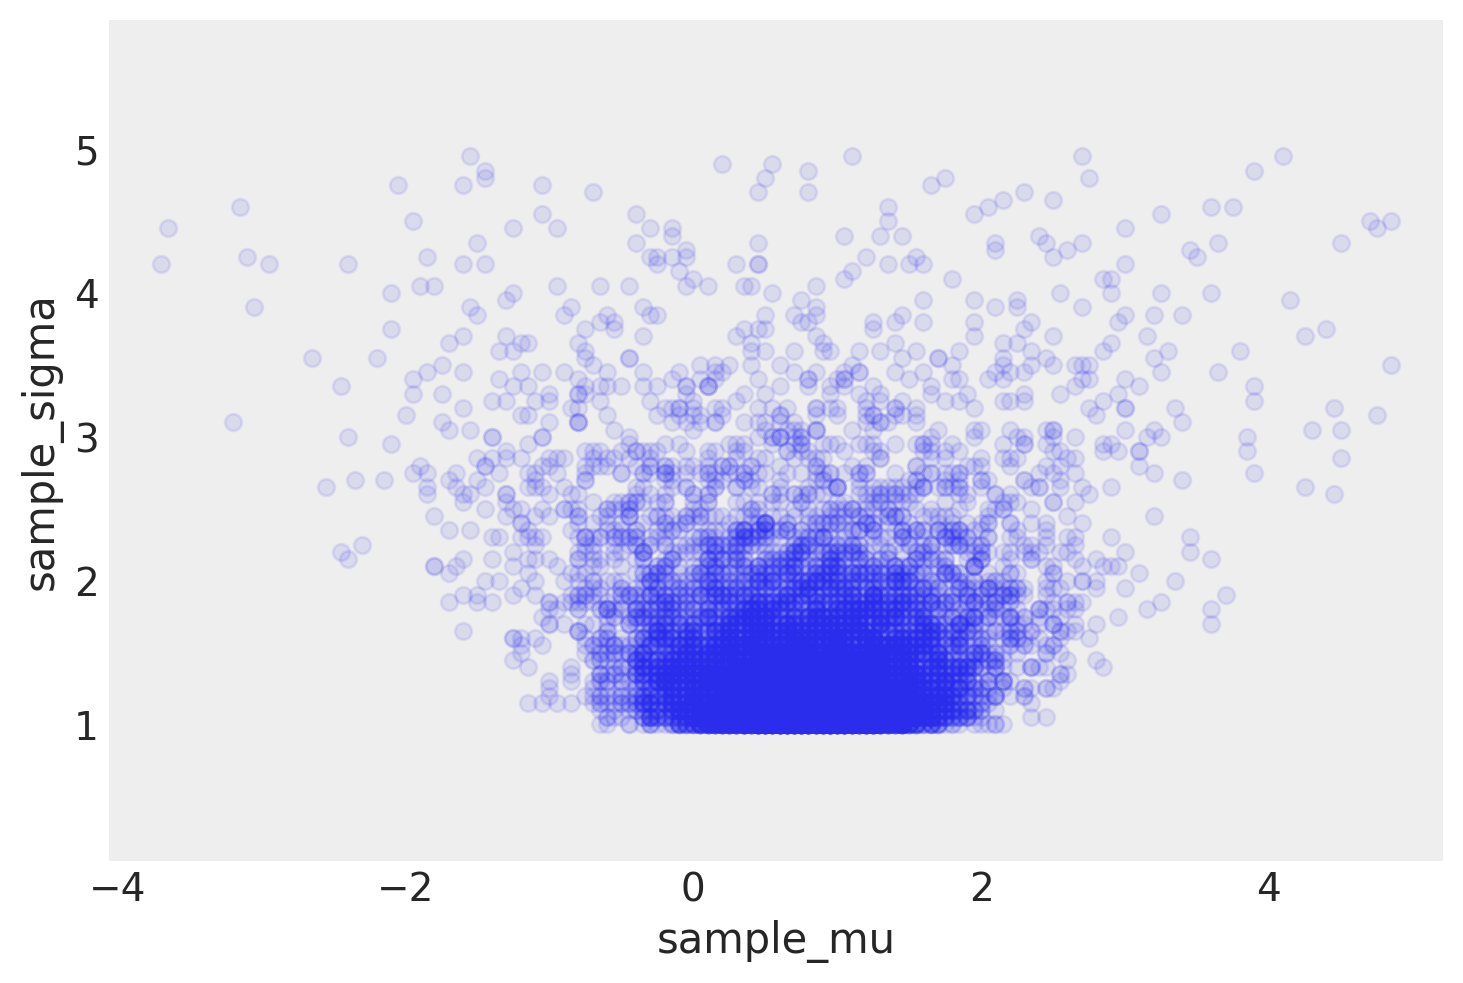

In [ ]:
## Sampling and Plotting
sample_index=np.random.choice(range(len(points)),p=normalized_posterior,replace=True,size=10000)
sample_mu=points[:,0][sample_index]
sample_sigma=points[:,1][sample_index]
fig,ax=plt.subplots()
ax.plot(sample_mu,sample_sigma,'o',alpha=0.1)
ax.axis("equal")
ax.grid(False)
ax.set_xlabel("sample_mu")
ax.set_ylabel("sample_sigma");

# Approximation using Metropolis Random Walk

One problem with Grid Appromiximation is that there are infinite numbers just between 0 and 1. Imagine this for some unknown ranges for multiple dimensions. That’s a lot of samples and a lot of computational time and power. Therefore it is now time to introduce the Metropolis random-walk algorithm which just optimizes Grid Approximation by making smart sampling choices. 


In [ ]:
sample=5000
trace=np.array([np.zeros(sample),np.zeros(sample)]).reshape(sample,2)
mu_current = 1
sigma_current= 5
width_size=0.5
def sampler(mu_current = 1,sigma_current= 5,width_size=0.5,sample=4):
  trace=np.array([np.zeros(sample),np.zeros(sample)]).reshape(sample,2)
  for i in range(sample):
    mu_proposal = stats.norm(mu_current, width_size).rvs()
    sigma_proposal=stats.uniform(1,sigma_current).rvs()


    ##priors mu
    prior_mu_current=stats.norm(0,10).pdf(mu_current)
    prior_mu_proposal=stats.norm(0,10).pdf(mu_proposal)
 
    ## priors sigma
    prior_sigma_current=stats.uniform(1,5).pdf(sigma_current)
    prior_sigma_proposal=stats.uniform(1,5).pdf(sigma_proposal)

    ##liklihood
    liklihood_current=stats.norm(mu_current,sigma_current).pdf(data).prod()
    liklihood_proposal=stats.norm(mu_proposal,sigma_proposal).pdf(data).prod()

    p_current=prior_mu_current*prior_sigma_current*liklihood_current
    p_proposal=prior_mu_proposal*prior_sigma_proposal*liklihood_proposal

    ##accept or reject
    p_accept = p_proposal / p_current

    # Usually would include prior probability, which we neglect here for simplicity
    accept = np.random.rand() < p_accept

    if accept:
        # Update position
        mu_current = mu_proposal
        sigma_current=sigma_proposal
    trace[:,0][i]=mu_current
    trace[:,1][i]=sigma_current
  return trace


In [ ]:
## Samples
trace_1=sampler(sample=500)
mu_mcmc_samples=trace_1[:,0]
sigma_mcmc_samples=trace_1[:,1]

## Diagnosing Parameter Values

[Text(0.5, 0, 'Sample Index( no of samples)'), Text(0.5, 1.0, 'Trace Sigma')]

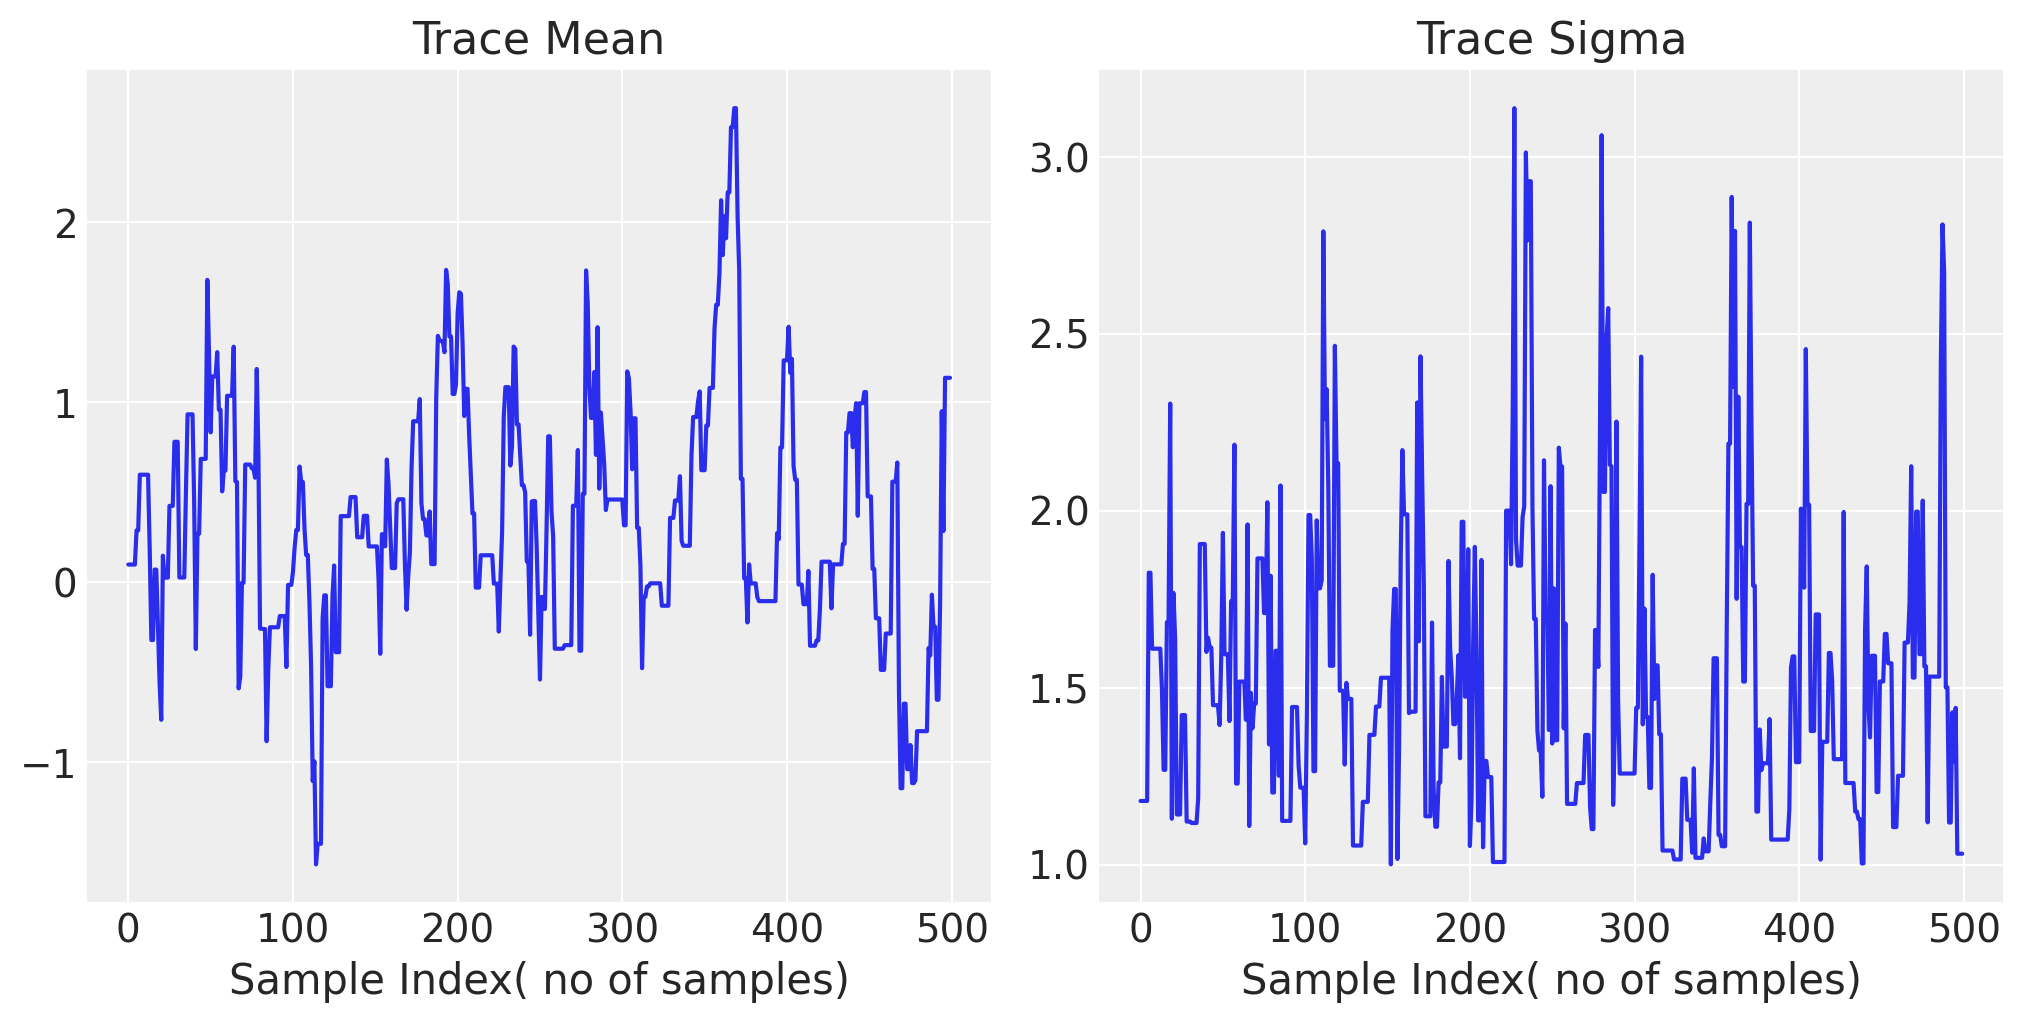

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].plot(mu_mcmc_samples)
axs[1].plot(sigma_mcmc_samples)

axs[0].set(title='Trace Mean',xlabel='Sample Index( no of samples)')
axs[1].set(title='Trace Sigma',xlabel='Sample Index( no of samples)')

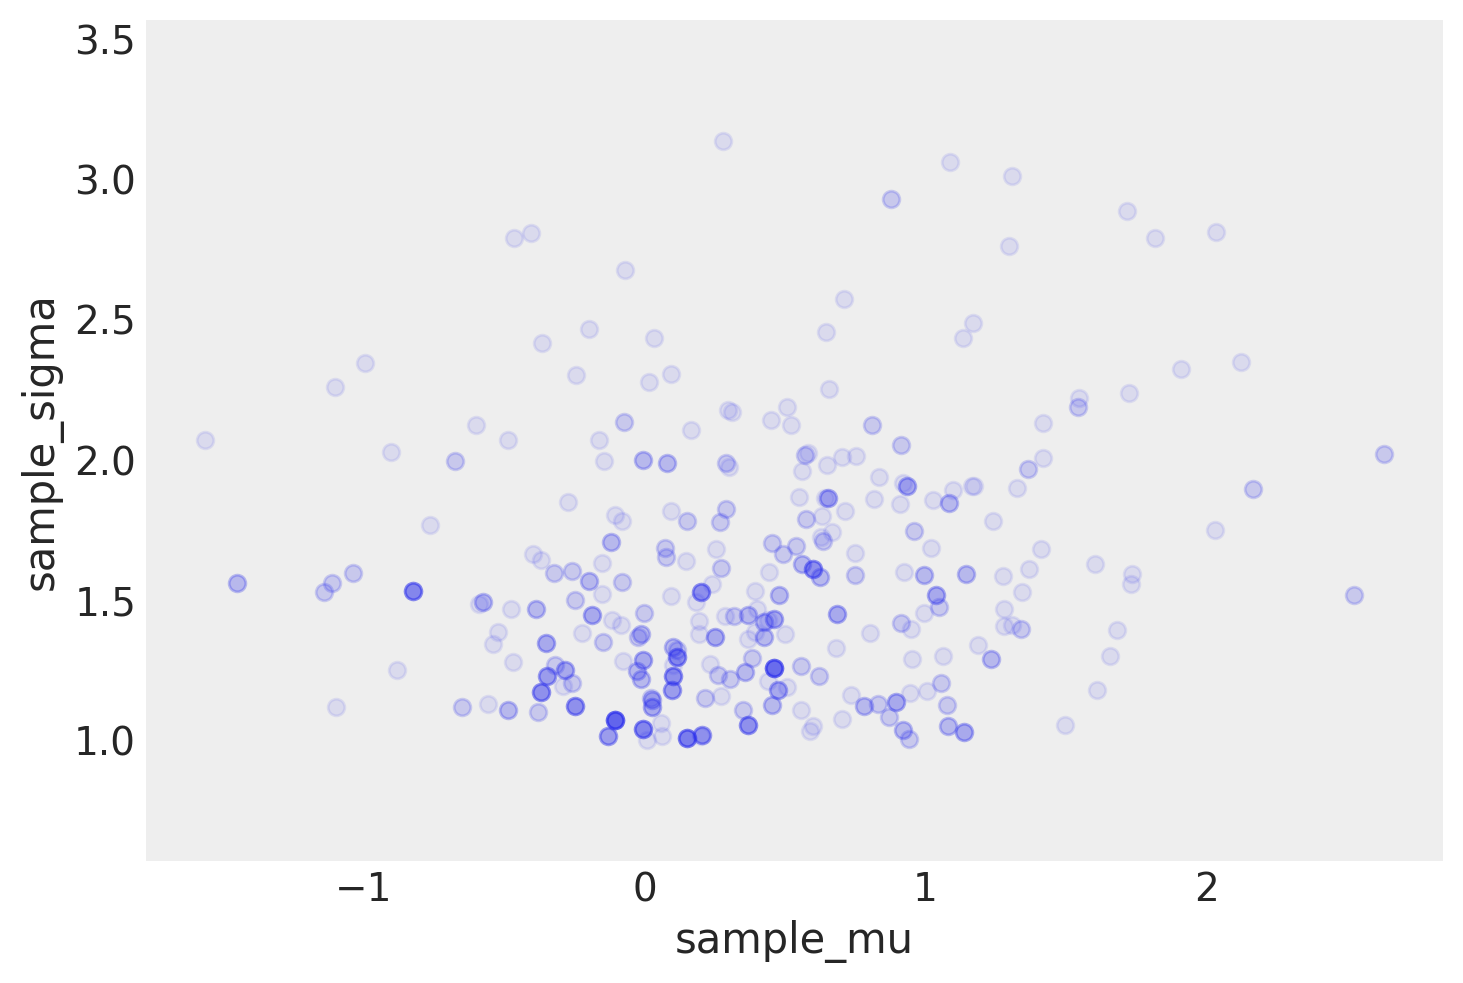

In [ ]:
fig,ax=plt.subplots()
ax.plot(mu_mcmc_samples,sigma_mcmc_samples,'o',alpha=0.1)
ax.axis("equal")
ax.grid(False)
ax.set_xlabel("sample_mu")
ax.set_ylabel("sample_sigma");

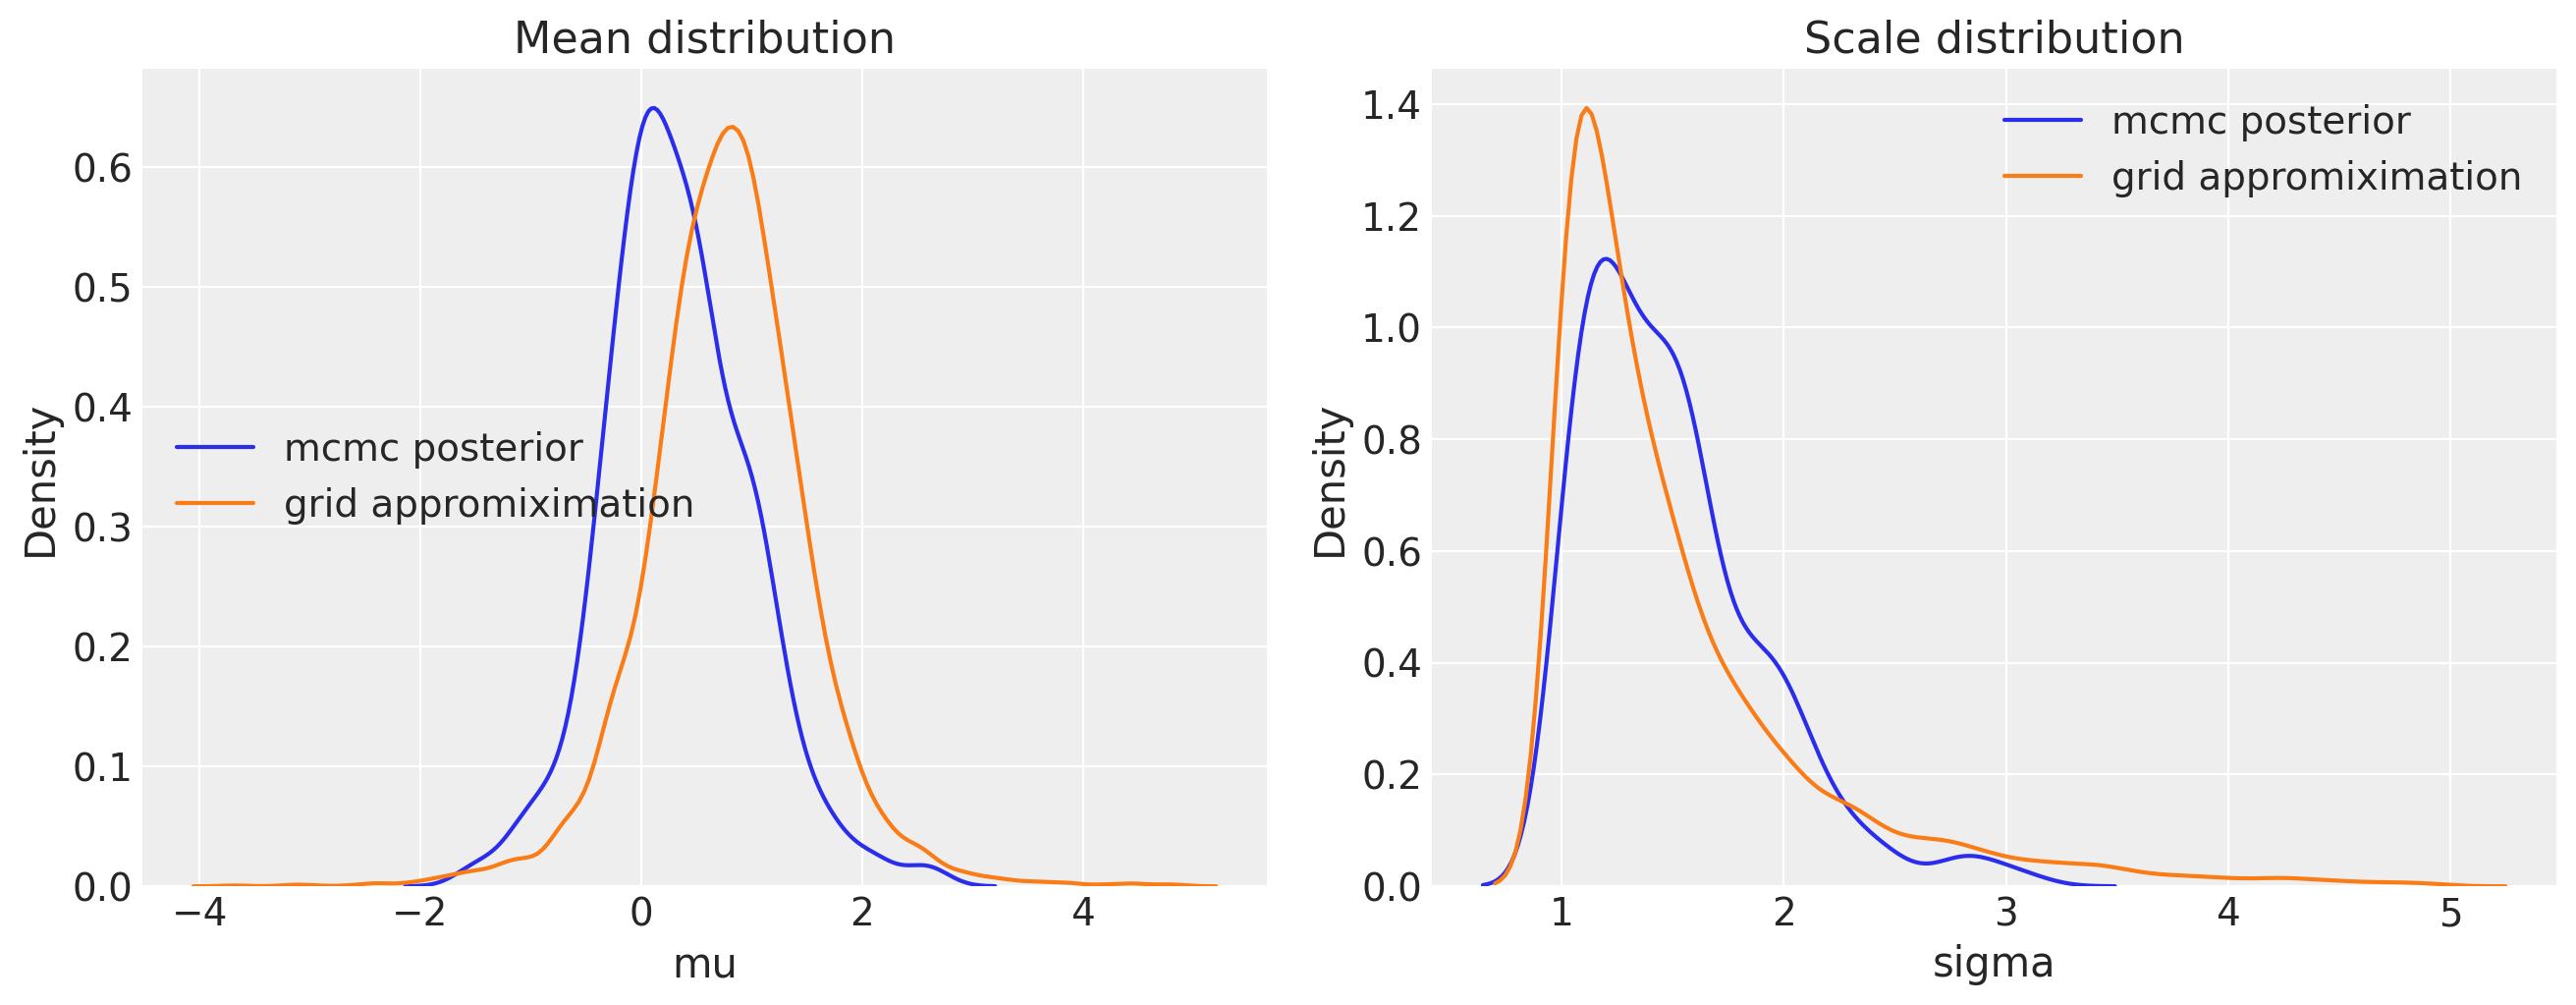

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(13,5))
sns.kdeplot(mu_mcmc_samples, ax=ax[0], label='mcmc posterior')
sns.kdeplot(sample_mu,ax=ax[0],label='grid appromiximation')
sns.kdeplot(sigma_mcmc_samples, ax=ax[1], label='mcmc posterior')
sns.kdeplot(sample_sigma,ax=ax[1],label='grid appromiximation')

ax[0].set(xlabel='mu',title="Mean distribution")
ax[1].set(xlabel='sigma',title="Scale distribution")
ax[0].legend()
ax[1].legend()